<a href="https://colab.research.google.com/github/hhboorstein/ds_portfolio/blob/main/DSBA_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Work Visa: Ensemble Methods

The number of applications for US work visas is growing. To assist with the review process, we will develop an ML solution to filter out many candidates. This filtering will be trained on a data set of previous applications and the resulting case statuses.

This data has features describing both the applicant and their sponsoring employer:

* case_id: unique identifier for each application

* continent: employee continent of origin

* education_of_employee: level of education

* has_job_experience: binary flag

* requires_job_training: binary flag

* no_of_employees: size of sponsoring employer's company

* yr_of_estab: sponsoring company's year of establishment

* region_of_employment: applicant's intended region of employment in the US

* prevailing_wage: regional average wage for a given domain of labor; useful to keep job market competative without underpaying foreign workers

* unit_of_wage: frequency of payment

* full_time_position: binary flag; Y: full time

* case_status: binary flag

## Importing necessary libraries and data

In [ ]:
!pip uninstall scikit-learn -y

!pip install -U scikit-learn

Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Successfully uninstalled scikit-learn-1.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.2 MB 1.1 MB/s 


In [ ]:
# math and data
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# model building
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

# models
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

In [ ]:
visa=pd.read_csv('dataset.csv')

In [ ]:
visa_copy=visa.copy()

## Data Overview


In [ ]:
visa.sample(10)

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
24759,EZYV24760,Europe,Bachelor's,Y,N,955,2001,Northeast,136814.79,Year,Y,Denied
17290,EZYV17291,Asia,Master's,Y,N,1305,2011,Midwest,221669.11,Year,N,Denied
11584,EZYV11585,Asia,Master's,Y,N,645,2007,Northeast,57470.10,Year,N,Certified
5717,EZYV5718,Europe,Master's,N,Y,3343,1911,West,147919.62,Year,Y,Certified
10098,EZYV10099,North America,Doctorate,Y,Y,1307,2001,South,25838.77,Year,Y,Certified
18484,EZYV18485,Asia,Master's,Y,N,1851,2007,Northeast,58934.94,Year,Y,Certified
8757,EZYV8758,North America,Bachelor's,Y,N,7778,1968,Northeast,115183.30,Year,Y,Certified
6137,EZYV6138,Asia,Master's,N,N,3406,2010,South,161136.84,Year,N,Certified
1178,EZYV1179,North America,Master's,Y,N,1409,2001,South,124682.10,Year,Y,Certified
12869,EZYV12870,Asia,High School,Y,N,2981,2006,Northeast,110582.48,Year,Y,Denied


In [ ]:
visa.shape

(25480, 12)

In [ ]:
visa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB


There are twelve features with 25480 records each. While we record no NaN values, there may very well be missing or erroneous data. Most of the columns are object type, which we can convert to categorical during our pre-processing later.

## Exploratory Data Analysis (EDA)

In [ ]:
visa.describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_employees,25480.0,5667.043210,22877.928848,-26.0000,1022.00,2109.00,3504.0000,602069.00
yr_of_estab,25480.0,1979.409929,42.366929,1800.0000,1976.00,1997.00,2005.0000,2016.00
prevailing_wage,25480.0,74455.814592,52815.942327,2.1367,34015.48,70308.21,107735.5125,319210.27


* We see that the minimum number of employees is -26, an impossibility! This indicates that we already have at least one apparent error in our data.

* The median number of employees is around 2100, so a midsize company. The largest in our records has over 600,000 employees.

* The oldest company we have records for was founded in 1800, but the mean year is around 1979.

* The median local wage is \$70,308.21, and the mean is several thousand higher, indicating some skew toward higher costs of living. There is at least one shockingly low value, as the minimum is just \$2.14. Perhaps this is hourly wage, though even then \$2/hr is quite low. This hints that we must diligently explore outliers for potential errors.

In [ ]:
visa.describe(include='object').T

,count,unique,top,freq
case_id,25480,25480,EZYV01,1
continent,25480,6,Asia,16861
education_of_employee,25480,4,Bachelor's,10234
has_job_experience,25480,2,Y,14802
requires_job_training,25480,2,N,22525
region_of_employment,25480,5,Northeast,7195
unit_of_wage,25480,4,Year,22962
full_time_position,25480,2,Y,22773
case_status,25480,2,Certified,17018


* With 25480 unique case IDs, we can be fairly confident that there are no duplicates in our records.

* The data covers 6 continents of origin, with Asia being the most frequent.

* The plurality of applicants have a Bachelor's level of education. We will explore the other levels on record shortly.

* The majority of applicants do have some job experience, and around 88% of jobs do not require training.

* Nearly all wages are recorded as yearly salaries, though the data dictionary indicates that hourly, weekly, and monthly are options too.

In [ ]:
for col in visa.drop('case_id',axis=1).select_dtypes('object').columns:
  print('Values in',col,'feature')
  print(visa[col].value_counts())
  print('-'*45)

Values in continent feature
Asia             16861
Europe            3732
North America     3292
South America      852
Africa             551
Oceania            192
Name: continent, dtype: int64
---------------------------------------------
Values in education_of_employee feature
Bachelor's     10234
Master's        9634
High School     3420
Doctorate       2192
Name: education_of_employee, dtype: int64
---------------------------------------------
Values in has_job_experience feature
Y    14802
N    10678
Name: has_job_experience, dtype: int64
---------------------------------------------
Values in requires_job_training feature
N    22525
Y     2955
Name: requires_job_training, dtype: int64
---------------------------------------------
Values in region_of_employment feature
Northeast    7195
South        7017
West         6586
Midwest      4307
Island        375
Name: region_of_employment, dtype: int64
---------------------------------------------
Values in unit_of_wage feature
Year 

* The only continent of origin not represented is (predictably) Antarctica. After Asia, the most common continents are Europe and North America (likely Canada and Mexico).

* Other than a Bachelor's degree, many applicants have a Master's. Some also have a high school diploma or a doctorate, but these are less common.

* There are five options for region of employment: Northeast, South, West, Midwest, and Island (in decreasing level of frequency). Northeast and South have nearly the same number of records.

* The dependent variable in this study is ```case_status```, with outcomes Certified or Denied. About two-thirds of cases are Certified.

In [ ]:
# quick plotting function
def plott(col=None):
  '''Quick plot a countplot for categorical
  data and a histogram for numeric data.'''
  plt.figure(figsize=(8,5))
  if col==None:
    return
  elif visa[col].dtype=='object':
    plt.title('Countplot of '+col,fontsize=14)
    sns.countplot(data=visa,x=col,
                  order=visa[col].value_counts().index.tolist());
  else:
    plt.title('Histogram of '+col,fontsize=14)
    sns.histplot(data=visa,x=col);

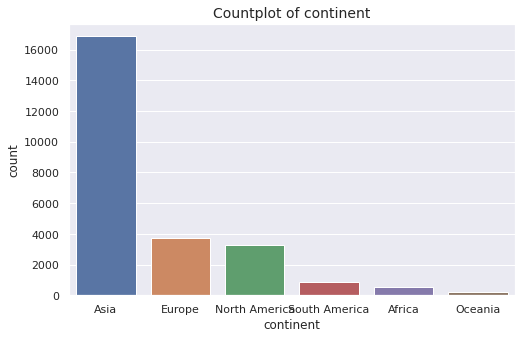

In [ ]:
plott('continent')

We find that Asia is by far the most frequent continent of origin, while Oceania is the least.

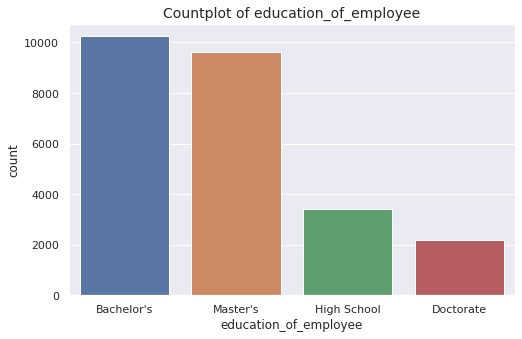

In [ ]:
plott('education_of_employee')

Bachelor's and Master's education are almost equally common, with both around 10000 records each.

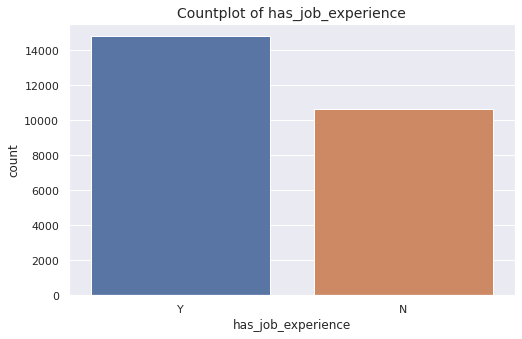

In [ ]:
plott('has_job_experience')

In [ ]:
visa['has_job_experience'].value_counts(normalize=True)

Y    0.580926
N    0.419074
Name: has_job_experience, dtype: float64

The majority of applicants have some job experience, but over 10000 (about 40%) have none.

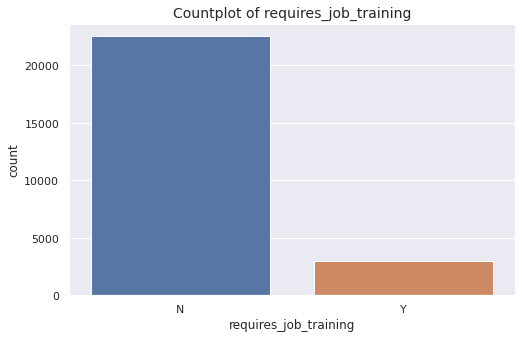

In [ ]:
plott('requires_job_training')

Unlike the previous feature, which had fairly balanced classes, most applicants do NOT require job training.

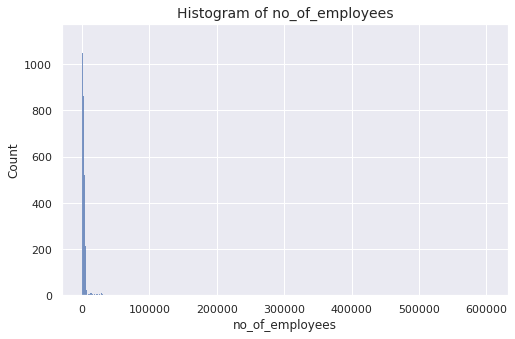

In [ ]:
plott('no_of_employees')

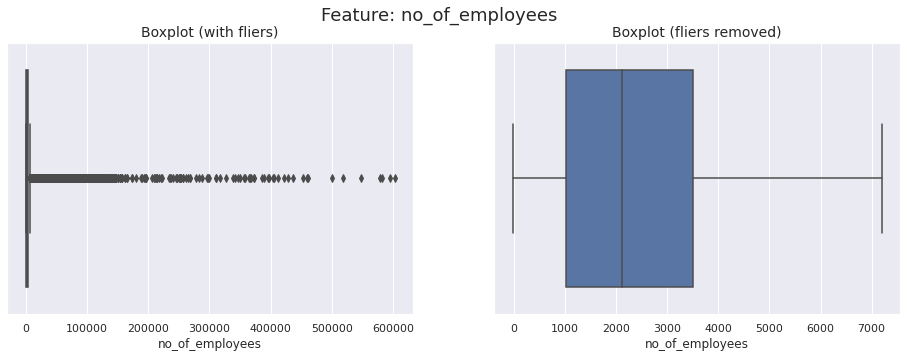

In [ ]:
plt.figure(figsize=(16,5))
plt.suptitle('Feature: no_of_employees',fontsize=18)

plt.subplot(1,2,1)
plt.title('Boxplot (with fliers)',fontsize=14)
sns.boxplot(data=visa,x='no_of_employees')

plt.subplot(1,2,2)
plt.title('Boxplot (fliers removed)',fontsize=14)
sns.boxplot(data=visa,x='no_of_employees',showfliers=False)

plt.show()

With such skewed data, the histogram lends little insight. Boxplots give a better idea of data concentration and distribution. Most of our records are concentrated below around 7000, but there are numerous extreme values on the high end.

We will not treat these extreme values though. It is entirely reasonable that many records reflect applicants to large companies.

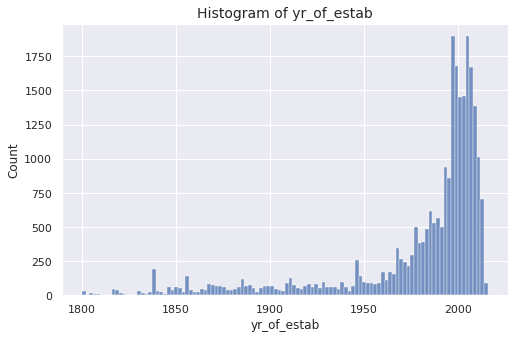

In [ ]:
plott('yr_of_estab')

In [ ]:
visa['yr_of_estab'].describe()

count    25480.000000
mean      1979.409929
std         42.366929
min       1800.000000
25%       1976.000000
50%       1997.000000
75%       2005.000000
max       2016.000000
Name: yr_of_estab, dtype: float64

We find that 75% of companies in our records were founded in 1976 or later. Like the previous feature, we have many extreme values, this time on the lower end. As before, all these values are entirely sensible, so we will not alter them.

However, we will convert this feature to 'years since founded', which will flip the distribution from left-skewed to right-skewed but otherwise leave the data unchanged.

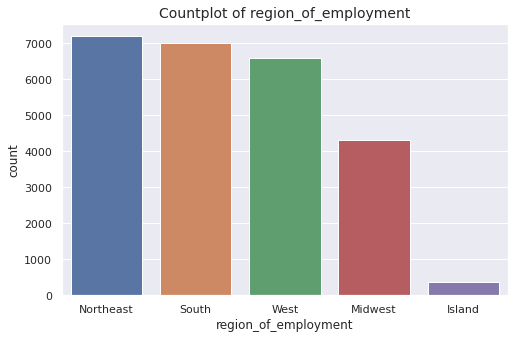

In [ ]:
plott('region_of_employment')

Northeast, South, and West are all common regions. Island is decidedly uncommon, with fewer than 500 records.

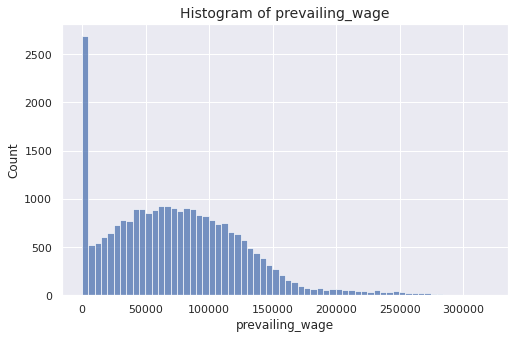

In [ ]:
plott('prevailing_wage')

Aside from the spike around \$0, prevailing wage follows a right-skewed normal distribution. It may well be that the spike is due to other wage units, such as hourly.

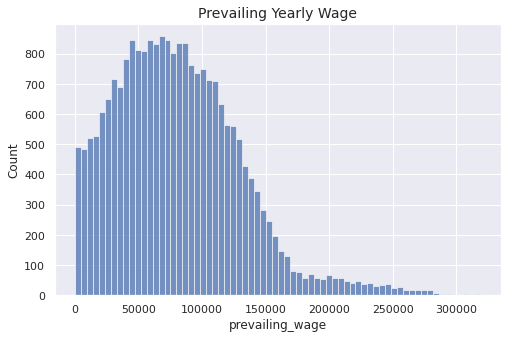

In [ ]:
plott()
plt.title('Prevailing Yearly Wage',fontsize=14)
sns.histplot(data=visa.loc[visa['unit_of_wage']=='Year'],
             x='prevailing_wage');

Indeed, the distribution looks far less erratic when just focused on yearly prevailing wage.

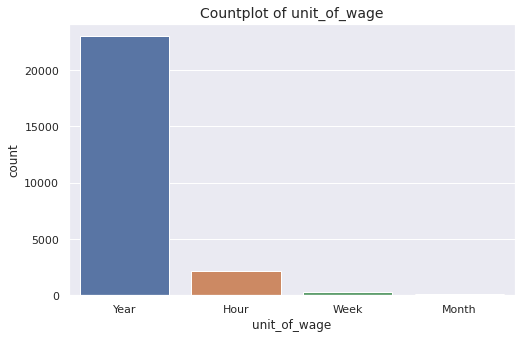

In [ ]:
plott('unit_of_wage')

Most of our records consider cases with yearly wages. Weekly and montly are vastly less common, as was shown earlier in the value counts table.

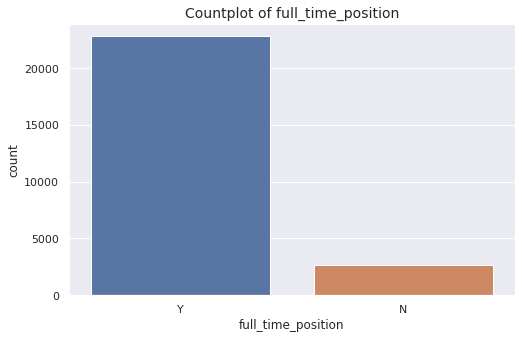

In [ ]:
plott('full_time_position')

Most positions are full time.

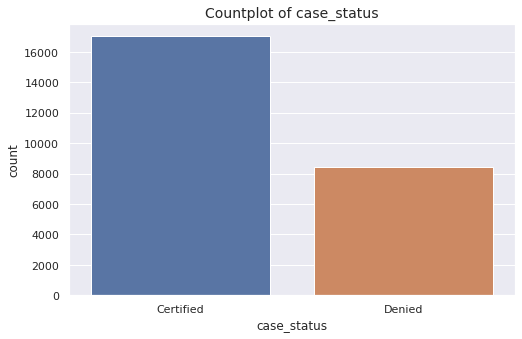

In [ ]:
plott('case_status')

Only one-thirds of cases are Denied.

In [ ]:
visa['case_status'].value_counts(normalize=True)

Certified    0.667896
Denied       0.332104
Name: case_status, dtype: float64

Let's dig deeper into prevailing wage.

In [ ]:
visa.groupby(by='unit_of_wage')['prevailing_wage'].describe().T

unit_of_wage,Hour,Month,Week,Year
count,2157.000000,89.000000,272.000000,22962.000000
mean,414.570513,87592.864045,85606.820515,81228.077133
std,275.015000,59525.124924,44802.704810,49951.473223
min,2.136700,1599.280000,2183.230000,100.000000
25%,152.700300,44986.240000,51408.277500,43715.955000
50%,372.652300,81826.010000,85075.820000,76174.500000
75%,637.311100,121629.600000,111331.910000,111341.960000
max,999.919500,264362.950000,280175.950000,319210.270000


I am skeptical about the records tagged with 'Week' for ```unit_of_wage```. According to our records, 75% of jobs with a weekly wage pay at least \$51,000 per WEEK! As we have limited visibility into the source of these data, we will preserve these records, but ideally I would like to do further research to justify these entries.

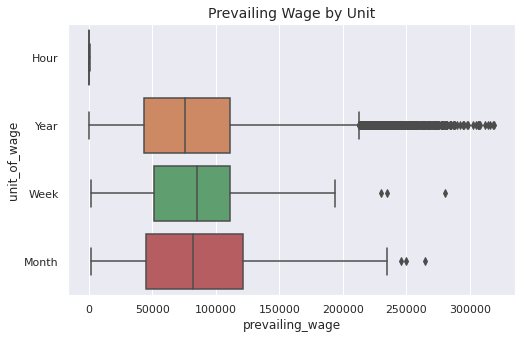

In [ ]:
plott()
plt.title('Prevailing Wage by Unit',fontsize=14)
sns.boxplot(data=visa,
             x='prevailing_wage',
             y='unit_of_wage');

The boxplot above is further evidence that weekly&mdash;and even monthly&mdash;data looks erroneous. Many of the weekly wages would result in a yearly earning well over a million USD! Perhaps this is personal bias, but it seems far fetched to have this many exceptionally high-paying jobs in this data set.

Without any evidence to the contrary, however, we will leave these records intact.

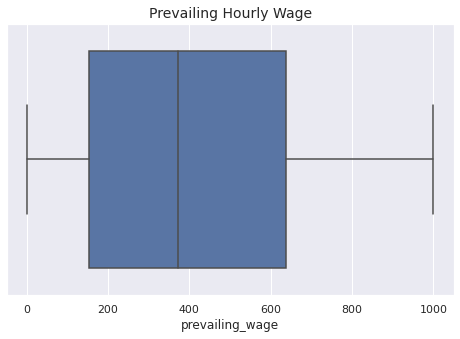

In [ ]:
plott()
plt.title('Prevailing Hourly Wage',fontsize=14)
sns.boxplot(data=visa.loc[visa['unit_of_wage']=='Hour'],
            x='prevailing_wage');

In [ ]:
b=visa.loc[visa['unit_of_wage']=='Hour']['prevailing_wage'].argmax()
visa.iloc[b]['full_time_position']

'Y'

In [ ]:
a=visa.loc[visa['unit_of_wage']=='Hour']['prevailing_wage'].max()
print('The maximum hourly wage is ${} for a full time position, equivalently ${} per year!'.format(a,2080*a))

The maximum hourly wage is $999.9195 for a full time position, equivalently $2079832.56 per year!


For the record, some hourly data points seem unreasonable too: The maximum wage is about \$1000 per hour, or around \$2 million per year. Again, there is no evidence that this data is necessarily erroneous; it simply stands out.

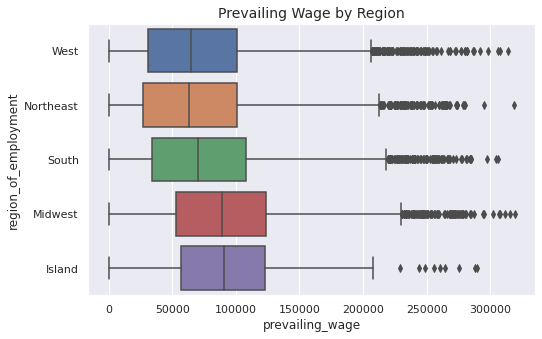

In [ ]:
plott()
plt.title('Prevailing Wage by Region',fontsize=14)
sns.boxplot(data=visa,
               x='prevailing_wage',
               y='region_of_employment');

The middle 50% of the data for prevailing wage is higher in the midwest and island regions. The northeast has the lowest first quartile. Every region has many extreme values on the high end.

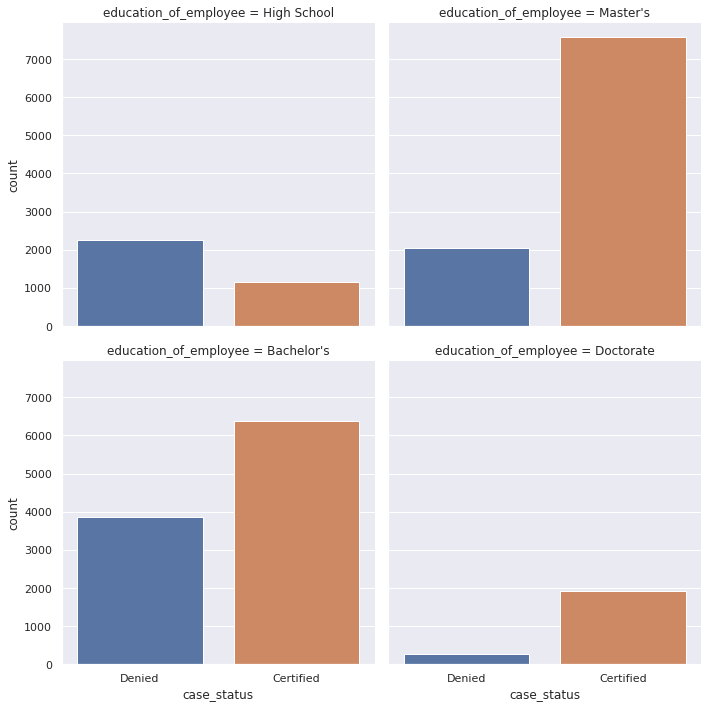

In [ ]:
sns.catplot(data=visa,
            x='case_status',
            col='education_of_employee',
            kind='count',
            col_wrap=2);

Looking toward our dependent variable, it appears that ```case_status``` is influenced by education. The trouble here is that it is difficult to compare the regions, as the scale is different for each. Is the _percentage_ Certified for Doctorate any greater or less than that for, say, Bachelor's?

Let's instead examine the percentage Certified and Denied.

In [ ]:
# dataframe of percentages
a=visa.groupby('education_of_employee')['case_status'].value_counts(normalize=True)
b=pd.DataFrame(index=['High School',"Bachelor's","Master's",'Doctorate'],
               columns=['Certified','Denied'])
for (c,d) in a.index:
  b.loc[c,d]=a[(c,d)]
b

,Certified,Denied
High School,0.340351,0.659649
Bachelor's,0.622142,0.377858
Master's,0.786278,0.213722
Doctorate,0.872263,0.127737


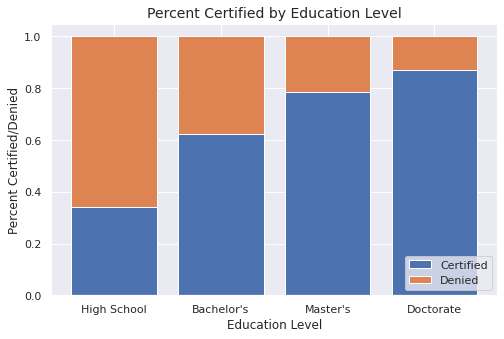

In [ ]:
# barplot of percentages
plott()
plt.title('Percent Certified by Education Level',fontsize=14)
plt.bar(b.index,
        b['Certified'],
        label='Certified')
plt.bar(b.index,
        b['Denied'],
        bottom=b['Certified'],
        label='Denied')
plt.legend(loc='lower right')
plt.xlabel('Education Level')
plt.ylabel('Percent Certified/Denied')
plt.show()

Indeed, here we can compare ```case_status``` on like scales. We find that applicants with a Doctorate are most often certified (over 87% of the time), while employees with only a High School education are certified around a third of the time. We find a clear trend: Visa status is directly connected with level of education. Higher levels of education lead to a greater percentage of visas certifed.

To plot the rest of our features as percentages, we make the above code into a function.

In [ ]:
def percent_status(col):
  '''Plot percent Certified/Denied
  for classes of a categorical variable.'''

  # generate dataframe of percentages
  a=visa.groupby(col)['case_status'].value_counts(normalize=True)
  #compute ascending order of classes
  ser=pd.Series(dtype='float')
  for name in visa[col].unique():
    ser[name]=a[(name,'Certified')]
  # dataframe
  b=pd.DataFrame(index=ser.sort_values().index.tolist(),
                 columns=['Certified','Denied'])
  for (c,d) in a.index:
    b.loc[c,d]=a[(c,d)]
  
  # plot percentages
  plott()
  plt.title('Percent Certified by '+col,fontsize=14)
  plt.bar(b.index,b['Certified'],label='Certified')
  plt.bar(b.index,b['Denied'],bottom=b['Certified'],label='Denied')
  plt.legend(loc='lower right')
  plt.xlabel(col)
  plt.ylabel('Percent Certified/Denied')
  plt.show()

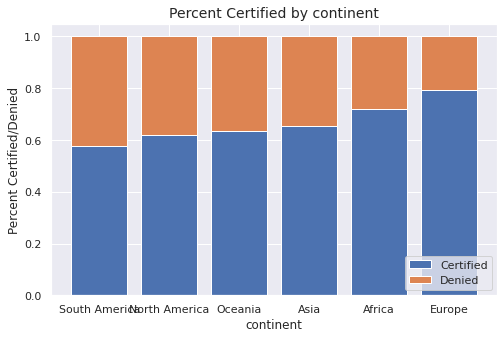

In [ ]:
percent_status('continent')

* Europe, Africa, and Asia see the greatest percentage of certified visas.
* South America sees the least.
* Every region has over 50% certification rate.

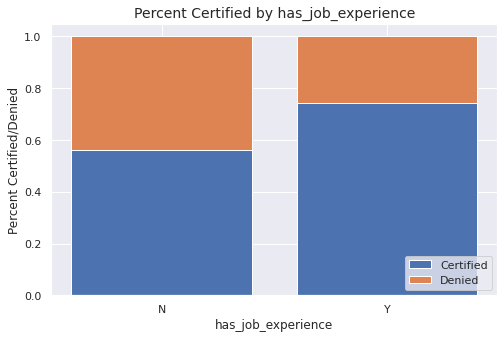

In [ ]:
percent_status('has_job_experience')

Having job experince certainly helps, as the proportion of Certified visas is higher for applicants with job experience. Let's test whether this difference is significant, assuming a level of siginificance of 5%. Please note that our populations are binomially distributed, independent, and simply randomly sampled; they furthermore satisfy the sample size inequalities. The assumptions for a two proportion z-test are therefore met. Our null hypothesis is that our sample proportions come from  populations with the same ratios of Certification to Denial; the alternative is that the ratios are truly different.

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

def cert_ztest(col):
  '''Run a two proportions independent
  z-test for case_status.'''
  # collect data
  size=visa[col].value_counts()
  a=visa.groupby(col)['case_status'].value_counts()
  cert=[]
  for idx in size.index.tolist():
    cert.append(a[idx,'Certified'])
  # run test
  t,p_val=proportions_ztest(cert,size)
  print('The p-value is',p_val)

In [ ]:
cert_ztest('has_job_experience')

The p-value is 1.2710489965841227e-206


With an astoundingly low p-value, we can confidently conclude that these sample proportions reflect a real-world difference for visa applications: We find that a greater proportion of applications are certified when the applicant has previous job experience.

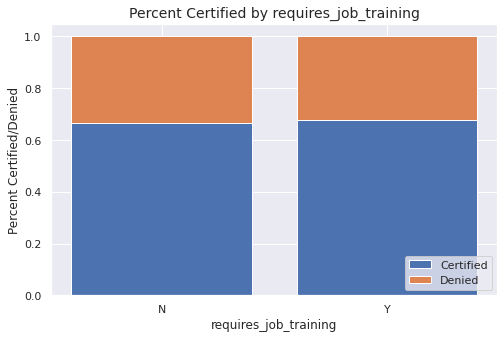

In [ ]:
percent_status('requires_job_training')

In [ ]:
visa.groupby('requires_job_training')['case_status'].value_counts(normalize=True)

requires_job_training  case_status
N                      Certified      0.666459
                       Denied         0.333541
Y                      Certified      0.678849
                       Denied         0.321151
Name: case_status, dtype: float64

Unlike the previous feature, the requirement of job training has very close proportions: 66.6% Certified (N) versus 67.9% (Y). There is apparently no difference in ```case_status``` based on the job training requirement. To confirm, we can run another two proportion z-test. (As before, the assumptions for the test are met.) We set the level of siginificance at 0.05. Our null hypothesis is that our sample proportions come from  populations with the same ratios of Certification to Denial; the alternative is that the ratios are truly different.

In [ ]:
cert_ztest('requires_job_training')

The p-value is 0.1787590242870024


Our p-value exceeds 0.05, so we fail to reject the null hypothesis. We must conclude that there is no significant difference between the two proportions. Put another way, ```requires_job_training``` does not impact ```case_status``` on its own.

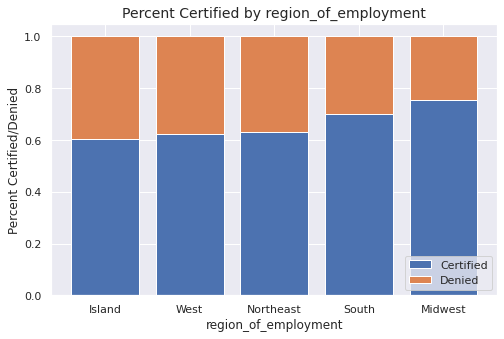

In [ ]:
percent_status('region_of_employment')

There seems to be little difference in visa certification rate among island, western, and northeastern jobs. The south and midwest look to have appreciably higher rates.

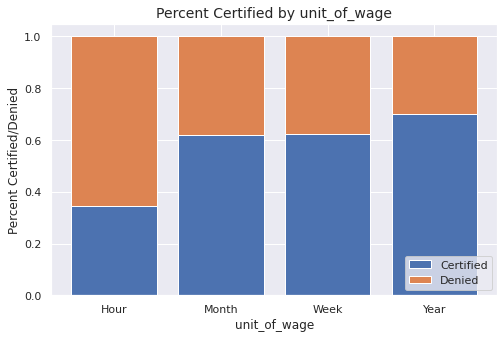

In [ ]:
percent_status('unit_of_wage')

Applicants to hourly jobs see far less than 50% certification. This is well below the rest, with yearly salaried jobs being most likely to lead to visa certification.

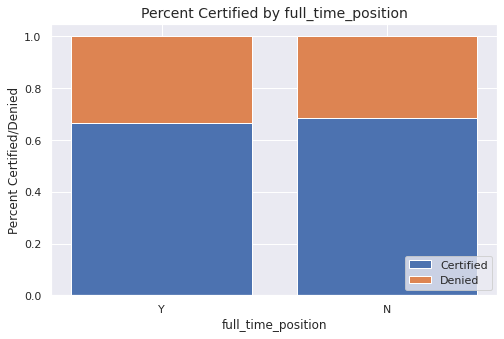

In [ ]:
percent_status('full_time_position')

In [ ]:
visa.groupby('full_time_position')['case_status'].value_counts(normalize=True)

full_time_position  case_status
N                   Certified      0.685260
                    Denied         0.314740
Y                   Certified      0.665832
                    Denied         0.334168
Name: case_status, dtype: float64

Similar to ```requires_job_training```, it appears here that there is not much difference in the resulting certification based on whether the position is full time. We find that 68.5% are Certified for part time work and 66.6% are Certified for full time work. Our assumptions being once more satisfied, we can run a two proportion z-test. We set the level of siginificance at 0.05. Our null hypothesis is that our sample proportions come from populations with the same ratios of Certification to Denial; the alternative is that the ratios are truly different.

In [ ]:
cert_ztest('full_time_position')

The p-value is 0.042452929825717224


With a p-value under 0.05, we can reject the null hypothesis. In this case, there is a statistically significant difference between these two proportions. That means that an applicant is more likely to be certified for part time work than full time work.

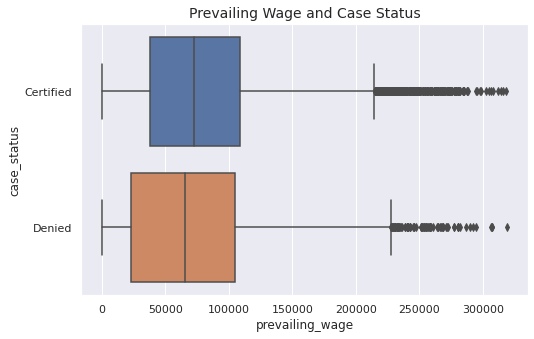

In [ ]:
plott()
plt.title('Prevailing Wage and Case Status',fontsize=14)
sns.boxplot(data=visa,x='prevailing_wage',
            y='case_status',
            order=['Certified','Denied']);

In [ ]:
visa.groupby('case_status')['prevailing_wage'].describe().T

case_status,Certified,Denied
count,17018.000000,8462.000000
mean,77293.619243,68748.681580
std,52042.715576,53890.166031
min,2.136700,2.956100
25%,38375.330000,23497.295000
50%,72486.270000,65431.460000
75%,108879.107500,105097.640000
max,318446.050000,319210.270000


The mean prevailing wage for certified applications is higher than that for denied applications by about \$8500. The middle 50% for certified is concentrated higher too. Interestingly, the whiskers extend further for denied applications. Taken with its wider IQR, this shows that denied applications have greater variance in prevailing wage.

This is also true across various regions.

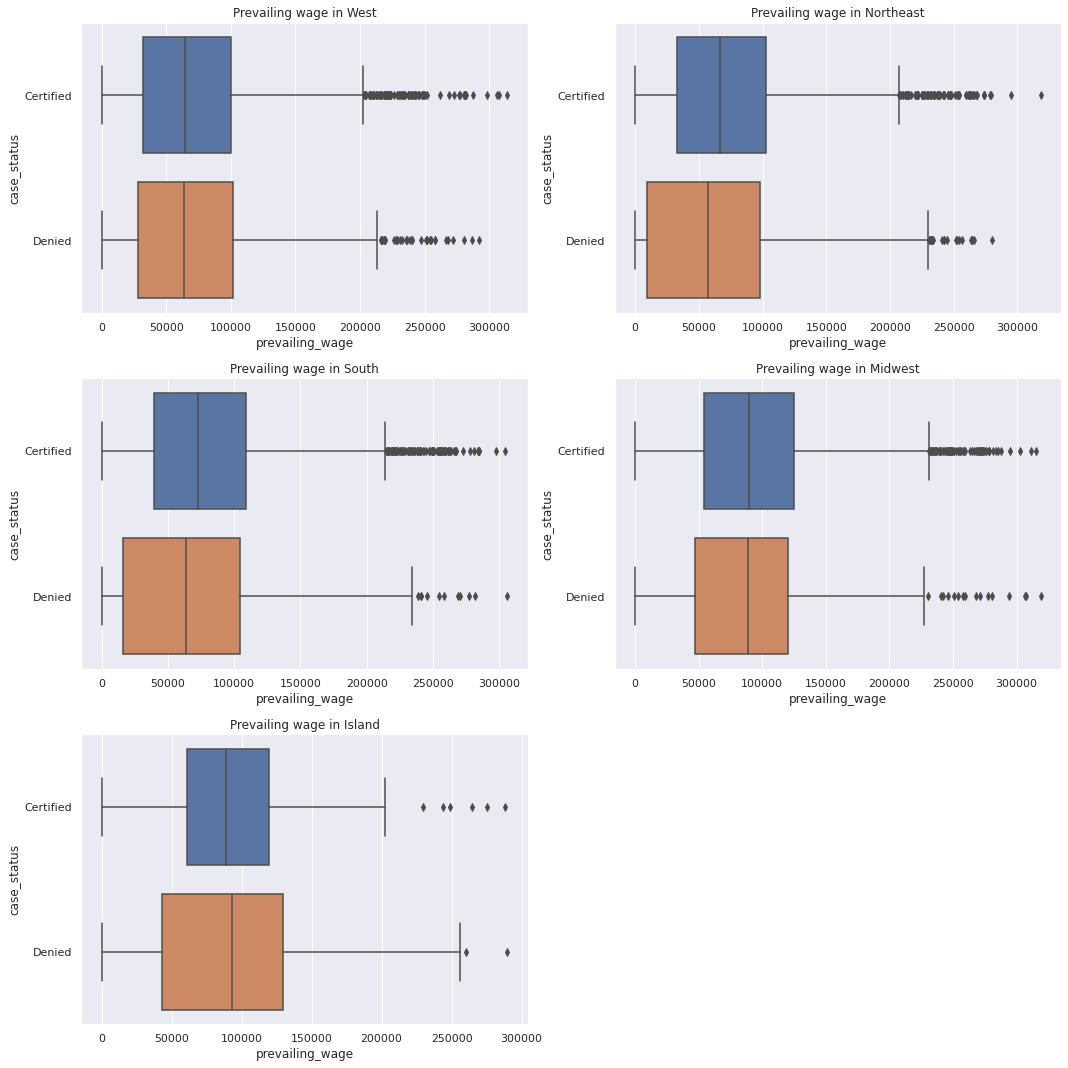

In [ ]:
plt.figure(figsize=(15,15))
for idx,region in enumerate(visa['region_of_employment'].unique()):
  plt.subplot(3,2,idx+1)
  plt.title('Prevailing wage in '+region)
  sns.boxplot(data=visa.loc[visa['region_of_employment']==region],
              x='prevailing_wage',
              y='case_status',
              order=['Certified','Denied'])
plt.tight_layout()

Denied applications in the northeast seem to have some of the lowest prevailing wages. The prevailing wages for the island region, on the other hand, appear generally higher than the rest, with certified cases having the greatest middle 50% among the regions. This is likely due to the higher cost of living on islands, as most goods must be imported.

## Data Preprocessing

### Feature Engineering

In [ ]:
visa['years_in_business']=2016-visa['yr_of_estab']
visa.drop('yr_of_estab',axis=1,inplace=True)

Rather than recording the year businesses were established, we will instead consider the number of years in business.

### Outlier detection and treatment

In [ ]:
visa.loc[visa['no_of_employees']<1].shape

(33, 12)

There are 33 records where the application lists a negative number of employees. These clearly constitute an error, and with no clear method to impute these values, our best recourse is to drop the rows.

In [ ]:
idx=visa.loc[visa['no_of_employees']<1].index
visa.drop(idx,axis=0,inplace=True)

### Data Prep

In [ ]:
visa.drop('case_id',axis=1,inplace=True)

We drop ```case_id```, as the unique identifiers will not lend any predictive power to our model.

In [ ]:
# convert object dtype to category
for col in visa.select_dtypes('object').columns:
  visa[col]=pd.Categorical(visa[col])

After making all object variables into category type, we encode them numerically.

In [ ]:
# define categorical ordering
order_struct={
    'education_of_employee':{'High School':1,
                             "Bachelor's":2,
                             "Master's":3,
                             'Doctorate':4},
    'has_job_experience':{'Y':1,'N':0},
    'requires_job_training':{'Y':1,'N':0},
    'full_time_position':{'Y':1,'N':0},
    'case_status':{'Certified':1,'Denied':0}
              }
no_order={'continent','region_of_employment','unit_of_wage'}

In [ ]:
# convert data to numeric
visa.replace(order_struct,inplace=True)
visa=pd.get_dummies(visa,columns=no_order)

We use one hot encoding for the categorical variables with no inherent order.

In [ ]:
X=visa.drop('case_status',axis=1)
y=visa['case_status']

In [ ]:
# split
X_train,X_test,y_train,y_test=train_test_split(X,y,
                                               test_size=0.3,
                                               stratify=y,
                                               random_state=57)

Now that we've split our data, it is ready for modeling.

## Second EDA


We only removed 33 records out of 25480. That's only 0.1% of the data. Accordingly, there is not enough change in our data to produce appreciably different visualizations. We only include plots for features that were directly altered/engineered. 

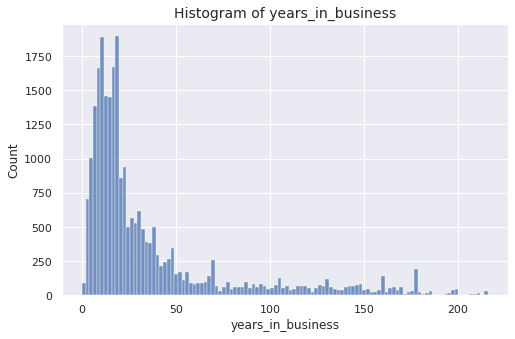

In [ ]:
plott('years_in_business')

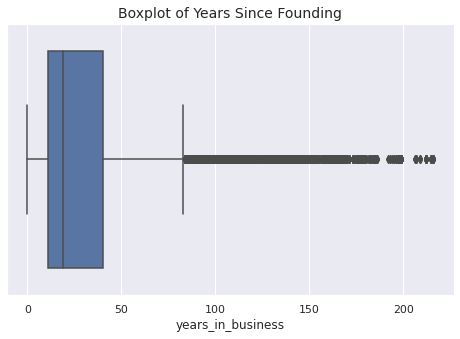

In [ ]:
plott()
plt.title('Boxplot of Years Since Founding',fontsize=14)
sns.boxplot(data=visa,x='years_in_business');

* We find that most businesses in our records are less than 50 years old.
* There are a steady supply of businesses greater than 75 years old, about the same amount for each year. It only starts to trail off after around 175 years.

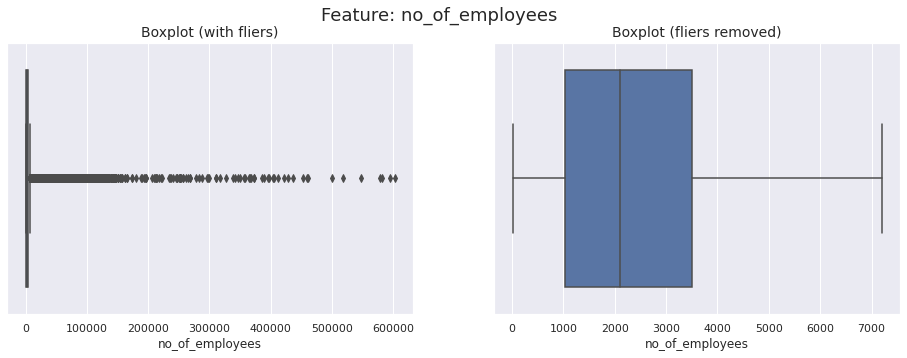

In [ ]:
plt.figure(figsize=(16,5))
plt.suptitle('Feature: no_of_employees',fontsize=18)

plt.subplot(1,2,1)
plt.title('Boxplot (with fliers)',fontsize=14)
sns.boxplot(data=visa,x='no_of_employees')

plt.subplot(1,2,2)
plt.title('Boxplot (fliers removed)',fontsize=14)
sns.boxplot(data=visa,x='no_of_employees',showfliers=False)

plt.show()

With so few records removed, there is little difference in the plots for number of employees. Put another way, the comments on this feature from the first EDA are still applicable. The middle 50% of observations is between about 1000 and 3500. There are also tiny companies, with not more than several employees, and massive companies, with over half a million employees, in our data set.

## Building bagging and boosting models

When scoring our models, we must find a good balance between false positives and false negatives.
* A false positive is a certified visa that should have been denied. We want to reduce false positives because these workers may be ineffective and not benefit the company.
* On the other hand, a false negative constitutes a denied visa that should have been certified. This deprives the workforce of an asset, someone who could benefit US companies.

With this in mind, we will score our models on F1, as it balances recall and precision, reducing both false positives and false negatives.

### Functions

In [ ]:
def scores(model):
  '''Print training and testing
  metrics for the specified model.'''

  score_idx=['Accuracy','Precision','Recall','F1']
  X_train_pred=model.predict(X_train)
  score_list_train=[metrics.accuracy_score(y_train,X_train_pred),
                    metrics.precision_score(y_train,X_train_pred),
                    metrics.recall_score(y_train,X_train_pred),
                    metrics.f1_score(y_train,X_train_pred)]

  X_test_pred=model.predict(X_test)
  score_list_test=[metrics.accuracy_score(y_test,X_test_pred),
                   metrics.precision_score(y_test,X_test_pred),
                   metrics.recall_score(y_test,X_test_pred),
                   metrics.f1_score(y_test,X_test_pred)]

  df=pd.DataFrame(index=score_idx)
  df['Train']=score_list_train
  df['Test']=score_list_test
  return df

This function gets the scores of a model on training data and testing data.

In [ ]:
model_comp_table=pd.DataFrame(columns=['Train Acc','Test Acc','Train F1','Test F1','Status'])
y_train_test_lens=[y_train.shape[0],y_test.shape[0]]

def tabulate(model,name):
  '''Compute train/test accuracy and
  F1 for a given model. Add to table.'''

  # run predictions with model
  X_train_pred=model.predict(X_train)
  X_test_pred=model.predict(X_test)

  # run overfitting test
  train_acc_count=np.logical_not(np.logical_xor(y_train,X_train_pred)).sum()
  test_acc_count=np.logical_not(np.logical_xor(y_test,X_test_pred)).sum()
  t,p_val=proportions_ztest([train_acc_count,test_acc_count],y_train_test_lens)
  
  # assign rating based on p-value
  rating=str()
  if p_val<0.05:
    rating='Overfit'
  else:
    rating='General'

  # collect data for new table row
  model_comp_table.loc[name]=[metrics.accuracy_score(y_train,X_train_pred),
                              metrics.accuracy_score(y_test,X_test_pred),
                              metrics.f1_score(y_train,X_train_pred),
                              metrics.f1_score(y_test,X_test_pred),
                              rating]

  return model_comp_table

This function adds accuracy and F1 scores to a DataFrame that we can use to compare models. It also runs a two proportion z-test to determine whether the training accuracy and testing accuracy are different enough for the model to be considered overfit. We assume a level of significance of 5% in the interpretation of the p-value. All conditions are necessarily met to justify the test.

In [ ]:
def confusion_heatmap(model,show_scores=False):
  '''Heatmap of confusion matrix of
  model predictions on test data.'''

  actual=y_test
  predicted=model.predict(X_test)
  # generate confusion matrix
  cm=metrics.confusion_matrix(actual,predicted)
  cm=np.flip(cm).T

  # heatmap labels
  labels=['TP','FP','FN','TN']
  cm_labels=np.array(cm).flatten()
  cm_percents=np.round((cm_labels/np.sum(cm))*100,3)
  annot_labels=[]
  for i in range(4):
    annot_labels.append(str(labels[i])+'\nCount:'+str(cm_labels[i])+'\n'+str(cm_percents[i])+'%')
  annot_labels=np.array(annot_labels).reshape(2,2)

  # print figure
  plt.figure(figsize=(8,5))
  plt.title('Confusion Matrix',fontsize=20)
  sns.heatmap(data=cm,
              annot=annot_labels,
              annot_kws={'fontsize':'x-large'},
              xticklabels=[1,0],
              yticklabels=[1,0],
              cmap='Greens',
              fmt='s')
  plt.xlabel('Actual',fontsize=14)
  plt.ylabel('Predicted',fontsize=14)
  plt.tight_layout();
  return

The function prints a heatmap with the confusion matrix for a given model.

### Bagging

#### Baseline: Decision Tree

In [ ]:
dtree=tree.DecisionTreeClassifier(random_state=1)
dtree.fit(X_train,y_train)

DecisionTreeClassifier(random_state=1)

As a baseline comparison, we train a single decision tree.

In [ ]:
scores(dtree)

,Train,Test
Accuracy,1.0,0.649902
Precision,1.0,0.741256
Recall,1.0,0.731229
F1,1.0,0.736208


Predictably, this model is comically overfit.

In [ ]:
tabulate(dtree,'dTree (baseline)')

,Train Acc,Test Acc,Train F1,Test F1,Status
dTree (baseline),1.0,0.649902,1.0,0.736208,Overfit


We add this model to a DataFrame that we will use to compare the different models.

#### Bagging Classifier

In [ ]:
bag=BaggingClassifier(random_state=1)
bag.fit(X_train,y_train)

BaggingClassifier(random_state=1)

The default estimator on a bagging classifier is a decision tree classifier, so this model consists of many parallel decision trees trained on samples taken with replacement (bootstrap samples).

In [ ]:
scores(bag)

,Train,Test
Accuracy,0.984168,0.698232
Precision,0.990625,0.770660
Recall,0.985630,0.780631
F1,0.988121,0.775614


In [ ]:
tabulate(bag,'Bagging Classifier')

,Train Acc,Test Acc,Train F1,Test F1,Status
dTree (baseline),1.000000,0.649902,1.000000,0.736208,Overfit
Bagging Classifier,0.984168,0.698232,0.988121,0.775614,Overfit


This model is also overfit. The test performance is nonetheless slightly better than the single decision tree.

#### Random Forest Classifier

In [ ]:
rf=RandomForestClassifier(random_state=1)
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=1)

In [ ]:
scores(rf)

,Train,Test
Accuracy,1.0,0.725082
Precision,1.0,0.771920
Recall,1.0,0.835326
F1,1.0,0.802373


As with the others, the random forest classifier overfits on the training data. Test performance is better than before, though this model is not generalized.

In [ ]:
tabulate(rf,'Random Forest')

,Train Acc,Test Acc,Train F1,Test F1,Status
dTree (baseline),1.000000,0.649902,1.000000,0.736208,Overfit
Bagging Classifier,0.984168,0.698232,0.988121,0.775614,Overfit
Random Forest,1.000000,0.725082,1.000000,0.802373,Overfit


### Boosting

#### AdaBoost

In [ ]:
abc=AdaBoostClassifier(random_state=1)
abc.fit(X_train,y_train)

AdaBoostClassifier(random_state=1)

In [ ]:
scores(abc)

,Train,Test
Accuracy,0.734786,0.733857
Precision,0.756469,0.755537
Recall,0.889328,0.889433
F1,0.817536,0.817036


The basic AdaBoost Classifier has good performance and does not suffer from overfitting. Accuracy on training and testing is around 73% and F1 is about 82%. This is a much more promising baseline.

In [ ]:
tabulate(abc,'AdaBoost')

,Train Acc,Test Acc,Train F1,Test F1,Status
dTree (baseline),1.000000,0.649902,1.000000,0.736208,Overfit
Bagging Classifier,0.984168,0.698232,0.988121,0.775614,Overfit
Random Forest,1.000000,0.725082,1.000000,0.802373,Overfit
AdaBoost,0.734786,0.733857,0.817536,0.817036,General


#### Gradient Boosting

In [ ]:
gbc=GradientBoostingClassifier(random_state=1)
gbc.fit(X_train,y_train)

GradientBoostingClassifier(random_state=1)

In [ ]:
scores(gbc)

,Train,Test
Accuracy,0.754997,0.749312
Precision,0.782289,0.780200
Recall,0.877479,0.869829
F1,0.827155,0.822581


Gradient Boosting also does not appear overfit, with the added bonus of slightly better performance over AdaBoost.
* Train and test accuracy is around 75%.
* Train and test F1 is around 82%.

In [ ]:
tabulate(gbc,'Gradient Boosting')

,Train Acc,Test Acc,Train F1,Test F1,Status
dTree (baseline),1.000000,0.649902,1.000000,0.736208,Overfit
Bagging Classifier,0.984168,0.698232,0.988121,0.775614,Overfit
Random Forest,1.000000,0.725082,1.000000,0.802373,Overfit
AdaBoost,0.734786,0.733857,0.817536,0.817036,General
Gradient Boosting,0.754997,0.749312,0.827155,0.822581,General


#### XGBoost

In [ ]:
xgbc=XGBClassifier(random_state=1)
xgbc.fit(X_train,y_train)

XGBClassifier(random_state=1)

In [ ]:
scores(xgbc)

,Train,Test
Accuracy,0.753762,0.750098
Precision,0.780624,0.779646
Recall,0.878235,0.872574
F1,0.826558,0.823497


XGBoost offers near identical performance to the gradient boosting above.

In [ ]:
tabulate(xgbc,'XGBoost')

,Train Acc,Test Acc,Train F1,Test F1,Status
dTree (baseline),1.000000,0.649902,1.000000,0.736208,Overfit
Bagging Classifier,0.984168,0.698232,0.988121,0.775614,Overfit
Random Forest,1.000000,0.725082,1.000000,0.802373,Overfit
AdaBoost,0.734786,0.733857,0.817536,0.817036,General
Gradient Boosting,0.754997,0.749312,0.827155,0.822581,General
XGBoost,0.753762,0.750098,0.826558,0.823497,General


##  Will tuning the hyperparameters improve the model performance?

### Bagging

#### Tuned Decision Tree

In [ ]:
dtree_tuned=tree.DecisionTreeClassifier(random_state=1)

params={'max_depth':np.arange(3,10),
        'min_samples_leaf':np.arange(5,10),
        'max_features':[None,'sqrt'],
        'max_leaf_nodes':np.arange(5,25,5),
        'min_impurity_decrease':[0.0,0.0005,0.001],
        'class_weight':[None,'balanced']}

* We will test values of tree depth from 3 to 9.
* We will consider limiting the maximum number of features to consider when calculating the best split.
* We will try balancing the class weights, though I don't expect this will improve performance.

In [ ]:
go=GridSearchCV(estimator=dtree_tuned,
                param_grid=params,
                scoring='f1',
                n_jobs=-1,
                cv=5,
                verbose=1)
go.fit(X_train,y_train)

Fitting 5 folds for each of 1680 candidates, totalling 8400 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                         'max_features': [None, 'sqrt'],
                         'max_leaf_nodes': array([ 5, 10, 15, 20]),
                         'min_impurity_decrease': [0.0, 0.0005, 0.001],
                         'min_samples_leaf': array([5, 6, 7, 8, 9])},
             scoring='f1', verbose=1)

In [ ]:
go.best_params_

{'class_weight': None,
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': 20,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5}

Grid Search Findings
* Our response variable is not so unbalanced that a rebalancing of class weights is required.
* A maximum tree depth of 7 seems to be ideal, with 20 as the upper bound for leaf nodes.
* The model requires at least 5 samples for each leaf. Along with limiting the depth and maximum number of leaves, this reduces overfitting.
* We get best performance when considering all features to determine the best split.

In [ ]:
dtree_tuned=go.best_estimator_

dtree_tuned.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=7, max_leaf_nodes=20, min_samples_leaf=5,
                       random_state=1)

We refit the best estimator on the full training set. (In the grid search, we employ cross validation, so there is a holdout set used to test each model. The upside is a more reliable search, but the cost is that we have yet to train the best estimator on the full training set.)

In [ ]:
scores(dtree_tuned)

,Train,Test
Accuracy,0.749382,0.750098
Precision,0.777421,0.779646
Recall,0.875546,0.872574
F1,0.823571,0.823497


In [ ]:
tabulate(dtree_tuned,'dTree (tuned)')

,Train Acc,Test Acc,Train F1,Test F1,Status
dTree (baseline),1.000000,0.649902,1.000000,0.736208,Overfit
Bagging Classifier,0.984168,0.698232,0.988121,0.775614,Overfit
Random Forest,1.000000,0.725082,1.000000,0.802373,Overfit
AdaBoost,0.734786,0.733857,0.817536,0.817036,General
Gradient Boosting,0.754997,0.749312,0.827155,0.822581,General
XGBoost,0.753762,0.750098,0.826558,0.823497,General
dTree (tuned),0.749382,0.750098,0.823571,0.823497,General


With around 75% accuracy, the tuned decision tree has similar performance to untuned boosting models. F1 score is around 82%. Importantly, tuning this tree has eliminated overfitting.

#### Tuned Bagging Classifier

In [ ]:
params={'base_estimator':[tree.DecisionTreeClassifier(random_state=2)],
        'base_estimator__max_depth':[None,1,2,3,4,5],
        'n_estimators':[10,20,30,40,50],
        'max_samples':[0.7,0.8,0.9,1.0],
        'max_features':[0.7,0.8,0.9,1.0],}

* We will test different depths for the base estimator (Decision Tree Classifier).
* We will consider between 10 and 50 estimators.
* Max samples and max features will also be adjusted, testing different fractions to include.

In [ ]:
bag_tuned=BaggingClassifier(random_state=1)

go=GridSearchCV(estimator=bag_tuned,
                param_grid=params,
                scoring='f1',
                n_jobs=-1,
                cv=5,
                verbose=1)

go.fit(X_train,y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


GridSearchCV(cv=5, estimator=BaggingClassifier(random_state=1), n_jobs=-1,
             param_grid={'base_estimator': [DecisionTreeClassifier(max_depth=5,
                                                                   random_state=2)],
                         'base_estimator__max_depth': [None, 1, 2, 3, 4, 5],
                         'max_features': [0.7, 0.8, 0.9, 1.0],
                         'max_samples': [0.7, 0.8, 0.9, 1.0],
                         'n_estimators': [10, 20, 30, 40, 50]},
             scoring='f1', verbose=1)

In [ ]:
go.best_params_

{'base_estimator': DecisionTreeClassifier(max_depth=5, random_state=2),
 'base_estimator__max_depth': 5,
 'max_features': 0.9,
 'max_samples': 0.8,
 'n_estimators': 10}

* Trees with a depth of 5 score best on F1.
* Our model performs better with fewer estimators.
* Taking less than 100% of the samples yields a higher-scoring model.

In [ ]:
bag_tuned=go.best_estimator_

bag_tuned.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                        random_state=2),
                  max_features=0.9, max_samples=0.8, random_state=1)

In [ ]:
scores(bag_tuned)

,Train,Test
Accuracy,0.738098,0.735298
Precision,0.747520,0.746795
Recall,0.918067,0.913546
F1,0.824062,0.821797


Note that the tuned bagging classifier has great recall. This model does a great job at reducing false negatives, meaning the US job market is not losing out on promising talent. On the other hand, precision is lower, which leaves us with an F1 score comparable to other generalized models.

In [ ]:
tabulate(bag_tuned,'Bagging clfr (tuned)')

,Train Acc,Test Acc,Train F1,Test F1,Status
dTree (baseline),1.000000,0.649902,1.000000,0.736208,Overfit
Bagging Classifier,0.984168,0.698232,0.988121,0.775614,Overfit
Random Forest,1.000000,0.725082,1.000000,0.802373,Overfit
AdaBoost,0.734786,0.733857,0.817536,0.817036,General
Gradient Boosting,0.754997,0.749312,0.827155,0.822581,General
XGBoost,0.753762,0.750098,0.826558,0.823497,General
dTree (tuned),0.749382,0.750098,0.823571,0.823497,General
Bagging clfr (tuned),0.738098,0.735298,0.824062,0.821797,General


As an experiment, we try another grid search with a second option for the base estimator: Logistic Regression.

In [ ]:
params={'base_estimator':[tree.DecisionTreeClassifier(random_state=2),
                          LogisticRegression(random_state=2,max_iter=1000)],
        'n_estimators':[10,20,30,40,50],
        'max_samples':[0.7,0.8,0.9,1.0],
        'max_features':[0.7,0.8,0.9,1.0],}

In [ ]:
bag_tuned=BaggingClassifier(random_state=1)

go=GridSearchCV(estimator=bag_tuned,
                param_grid=params,
                scoring='f1',
                n_jobs=-1,
                cv=5,
                verbose=1)

go.fit(X_train,y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(cv=5, estimator=BaggingClassifier(random_state=1), n_jobs=-1,
             param_grid={'base_estimator': [DecisionTreeClassifier(random_state=2),
                                            LogisticRegression(max_iter=1000,
                                                               random_state=2)],
                         'max_features': [0.7, 0.8, 0.9, 1.0],
                         'max_samples': [0.7, 0.8, 0.9, 1.0],
                         'n_estimators': [10, 20, 30, 40, 50]},
             scoring='f1', verbose=1)

In [ ]:
go.best_params_

{'base_estimator': DecisionTreeClassifier(random_state=2),
 'max_features': 0.7,
 'max_samples': 0.8,
 'n_estimators': 50}

After fitting the grid search, we find that the decision tree classifier was still the strongest base estimator for our metric. However, this time more estimators were required.

In [ ]:
scores(go)

,Train,Test
Accuracy,0.996351,0.722200
Precision,0.995313,0.749916
Recall,0.999244,0.876495
F1,0.997274,0.808280


It appears our model now overfits, as we have not limited the tree depth. We will not consider this model.

#### Tuned Random Forest

In [ ]:
params={'n_estimators':np.append(np.arange(150,350,50),1000),
        'max_depth':np.arange(1,6),
        'min_samples_split':np.arange(4,9),
        'max_features':['sqrt','log2'],
        'max_samples':[0.25,0.5,0.75,1.0]}

* We consider a number of estimators between 150 and 300. We also consider a huge model: 1000 trees.
* Various depths will be studied.
* As with the previous bagging model, we will test various values for the maximum number of features and samples.

In [ ]:
rf_tuned=RandomForestClassifier(random_state=1,warm_start=True)

go=GridSearchCV(estimator=rf_tuned,
                param_grid=params,
                scoring='f1',
                n_jobs=-1,
                cv=5,
                verbose=1)

go.fit(X_train,y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(random_state=1, warm_start=True),
             n_jobs=-1,
             param_grid={'max_depth': array([1, 2, 3, 4, 5]),
                         'max_features': ['sqrt', 'log2'],
                         'max_samples': [0.25, 0.5, 0.75, 1.0],
                         'min_samples_split': array([4, 5, 6, 7, 8]),
                         'n_estimators': array([ 150,  200,  250,  300, 1000])},
             scoring='f1', verbose=1)

In [ ]:
go.best_params_

{'max_depth': 5,
 'max_features': 'sqrt',
 'max_samples': 0.75,
 'min_samples_split': 7,
 'n_estimators': 300}

* Limiting the number of features at each split by the square root of the total number of features yielded better results than by using log base 2.
* A maximum tree depth of 5 worked best.
* We required 250 estimators in the highest scoring model.

In [ ]:
# train best estimator omitting warm_start parameter
rf_tuned=RandomForestClassifier(max_depth=5,
                                max_features='sqrt',
                                max_samples=0.75,
                                min_samples_split=8,
                                n_estimators=250,
                                random_state=1)

rf_tuned.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, max_samples=0.75, min_samples_split=8,
                       n_estimators=250, random_state=1)

In [ ]:
scores(rf_tuned)

,Train,Test
Accuracy,0.725803,0.723772
Precision,0.729101,0.727011
Recall,0.938151,0.939228
F1,0.820520,0.819605


Similar to the tuned bagging classifier above, we're getting over 90% recall with this model. Unfortunately, accuracy is still below 75% and F1 is no higher than before.

In [ ]:
tabulate(rf_tuned,'Random Forest (tuned)')

,Train Acc,Test Acc,Train F1,Test F1,Status
dTree (baseline),1.000000,0.649902,1.000000,0.736208,Overfit
Bagging Classifier,0.984168,0.698232,0.988121,0.775614,Overfit
Random Forest,1.000000,0.725082,1.000000,0.802373,Overfit
AdaBoost,0.734786,0.733857,0.817536,0.817036,General
Gradient Boosting,0.754997,0.749312,0.827155,0.822581,General
XGBoost,0.753762,0.750098,0.826558,0.823497,General
dTree (tuned),0.749382,0.750098,0.823571,0.823497,General
Bagging clfr (tuned),0.738098,0.735298,0.824062,0.821797,General
Random Forest (tuned),0.725803,0.723772,0.820520,0.819605,General


### Boosting

#### Tuned AdaBoost

In [ ]:
params={'base_estimator':[tree.DecisionTreeClassifier(random_state=2)],
        'base_estimator__max_depth':[1,2,3],
        'n_estimators':np.arange(10,80,10),
        'learning_rate':np.linspace(0.1,1,10)}

Next we'll train an AdaBoost classifier, using a decision tree as the base estimator. We will consider between 10 and 70 estimators within the ensemble, various depths of the trees, and several different learning rates.

In [ ]:
abc_tuned=AdaBoostClassifier(random_state=1)

go=GridSearchCV(estimator=abc_tuned,
                param_grid=params,
                scoring='f1',
                n_jobs=-1,
                cv=5,
                verbose=1)

go.fit(X_train,y_train)

Fitting 5 folds for each of 210 candidates, totalling 1050 fits


GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=1), n_jobs=-1,
             param_grid={'base_estimator': [DecisionTreeClassifier(max_depth=3,
                                                                   random_state=2)],
                         'base_estimator__max_depth': [1, 2, 3],
                         'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'n_estimators': array([10, 20, 30, 40, 50, 60, 70])},
             scoring='f1', verbose=1)

In [ ]:
go.best_params_

{'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=2),
 'base_estimator__max_depth': 3,
 'learning_rate': 0.1,
 'n_estimators': 50}

With a depth of 3 and a slower learning rate, our best model required 50 estimators.

In [ ]:
abc_tuned=go.best_estimator_

abc_tuned.fit(X_train,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=2),
                   learning_rate=0.1, random_state=1)

In [ ]:
scores(abc_tuned)

,Train,Test
Accuracy,0.750561,0.749050
Precision,0.778933,0.778166
Recall,0.874958,0.873358
F1,0.824158,0.823019


We get similar F1 performance to the tuned random forest, but better accuracy. Recall is lower than some other models.

In [ ]:
tabulate(abc_tuned,'AdaBoost (tuned)')

,Train Acc,Test Acc,Train F1,Test F1,Status
dTree (baseline),1.000000,0.649902,1.000000,0.736208,Overfit
Bagging Classifier,0.984168,0.698232,0.988121,0.775614,Overfit
Random Forest,1.000000,0.725082,1.000000,0.802373,Overfit
AdaBoost,0.734786,0.733857,0.817536,0.817036,General
Gradient Boosting,0.754997,0.749312,0.827155,0.822581,General
XGBoost,0.753762,0.750098,0.826558,0.823497,General
dTree (tuned),0.749382,0.750098,0.823571,0.823497,General
Bagging clfr (tuned),0.738098,0.735298,0.824062,0.821797,General
Random Forest (tuned),0.725803,0.723772,0.820520,0.819605,General
AdaBoost (tuned),0.750561,0.749050,0.824158,0.823019,General


#### Tuned Gradient Boosting

In [ ]:
params={'init':[None,'zero',AdaBoostClassifier(random_state=2)],
        'n_estimators':[50,75,100,150],
        'max_features':[None,'sqrt']+np.linspace(0.7,1.0,4).tolist()}

We will next tune the gradient booster with several different initialization conditions. We will also check the number of estimators and the maximum number of features when looking for the best split.

In [ ]:
gbc_tuned=GradientBoostingClassifier(random_state=1,
                                     warm_start=True)

go=GridSearchCV(estimator=gbc_tuned,
                param_grid=params,
                scoring='f1',
                n_jobs=-1,
                cv=5,
                verbose=1)

go.fit(X_train,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(random_state=1,
                                                  warm_start=True),
             n_jobs=-1,
             param_grid={'init': [None, 'zero',
                                  AdaBoostClassifier(random_state=2)],
                         'max_features': [None, 'sqrt', 0.7, 0.7999999999999999,
                                          0.9, 1.0],
                         'n_estimators': [50, 75, 100, 150]},
             scoring='f1', verbose=1)

In [ ]:
go.best_params_

{'init': 'zero', 'max_features': 0.7, 'n_estimators': 50}

In [ ]:
# train best estimator omitting warm_start parameter
gbc_tuned=GradientBoostingClassifier(random_state=1,
                                     init=AdaBoostClassifier(random_state=2),
                                     max_features=0.7,
                                     n_estimators=100)

gbc_tuned.fit(X_train,y_train)

GradientBoostingClassifier(init=AdaBoostClassifier(random_state=2),
                           max_features=0.7, random_state=1)

In [ ]:
scores(gbc_tuned)

,Train,Test
Accuracy,0.754379,0.751801
Precision,0.782449,0.782020
Recall,0.875882,0.871398
F1,0.826533,0.824293


As with AdaBoost, our accuracy is over 75%. The F1 score does not seem to be able to improve above 82%.

In [ ]:
tabulate(gbc_tuned,'Grad Boost (tuned)')

,Train Acc,Test Acc,Train F1,Test F1,Status
dTree (baseline),1.000000,0.649902,1.000000,0.736208,Overfit
Bagging Classifier,0.984168,0.698232,0.988121,0.775614,Overfit
Random Forest,1.000000,0.725082,1.000000,0.802373,Overfit
AdaBoost,0.734786,0.733857,0.817536,0.817036,General
Gradient Boosting,0.754997,0.749312,0.827155,0.822581,General
XGBoost,0.753762,0.750098,0.826558,0.823497,General
dTree (tuned),0.749382,0.750098,0.823571,0.823497,General
Bagging clfr (tuned),0.738098,0.735298,0.824062,0.821797,General
Random Forest (tuned),0.725803,0.723772,0.820520,0.819605,General
AdaBoost (tuned),0.750561,0.749050,0.824158,0.823019,General


#### Tuned XGBoost

In [ ]:
params={'eta':[0.1,0.2,0.3],
        'gamma':[0,2],
        'subsample':[0.5,0.75,1.0],
        'colsample_by_tree':[0.5,0.75,1.0],
        'colsample_bylevel':[0.5,0.75,1.0],
        'scale_pos_weight':[0.5,1.0]}

We will try many parameters for XGBoost.
* The parameter eta is the learning rate for the model.
* The parameter gamma concern loss reduction when partitioning a leaf node on a tree.
* Several sampling parameters control how the model samples the training data during fitting.
* The last parameter (```scale_pos_weight```) can help with biased classes in the response variable.

In [ ]:
xgbc_tuned=XGBClassifier(random_state=1)

go=GridSearchCV(estimator=xgbc_tuned,
                param_grid=params,
                scoring='f1',
                cv=5,
                verbose=1)

go.fit(X_train,y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=5, estimator=XGBClassifier(random_state=1),
             param_grid={'colsample_by_tree': [0.5, 0.75, 1.0],
                         'colsample_bylevel': [0.5, 0.75, 1.0],
                         'eta': [0.1, 0.2, 0.3], 'gamma': [0, 2],
                         'scale_pos_weight': [0.5, 1.0],
                         'subsample': [0.5, 0.75, 1.0]},
             scoring='f1', verbose=1)

In [ ]:
go.best_params_

{'colsample_by_tree': 0.5,
 'colsample_bylevel': 1.0,
 'eta': 0.1,
 'gamma': 0,
 'scale_pos_weight': 1.0,
 'subsample': 1.0}

* A lower learning rate ended up being better for F1.
* The classifier did not need to adjust class weights for better performance.
* While ```colsample_by_tree``` is less than 100%, both ```colsample_by_level``` and ```subsample``` are maxed out at 1.

In [ ]:
xgbc_tuned=go.best_estimator_

xgbc_tuned.fit(X_train,y_train)

XGBClassifier(colsample_by_tree=0.5, colsample_bylevel=1.0, eta=0.1,
              random_state=1, scale_pos_weight=1.0, subsample=1.0)

In [ ]:
scores(xgbc_tuned)

,Train,Test
Accuracy,0.753762,0.750098
Precision,0.780624,0.779646
Recall,0.878235,0.872574
F1,0.826558,0.823497


After training the best estimator on the full training set, we find that performance is comparable&mdash;in fact, nearly identical&mdash;to the other tuned boosting models.

In [ ]:
tabulate(xgbc_tuned,'XGBoost (tuned)')

,Train Acc,Test Acc,Train F1,Test F1,Status
dTree (baseline),1.000000,0.649902,1.000000,0.736208,Overfit
Bagging Classifier,0.984168,0.698232,0.988121,0.775614,Overfit
Random Forest,1.000000,0.725082,1.000000,0.802373,Overfit
AdaBoost,0.734786,0.733857,0.817536,0.817036,General
Gradient Boosting,0.754997,0.749312,0.827155,0.822581,General
XGBoost,0.753762,0.750098,0.826558,0.823497,General
dTree (tuned),0.749382,0.750098,0.823571,0.823497,General
Bagging clfr (tuned),0.738098,0.735298,0.824062,0.821797,General
Random Forest (tuned),0.725803,0.723772,0.820520,0.819605,General
AdaBoost (tuned),0.750561,0.749050,0.824158,0.823019,General


#### Stacking Classifier

In [ ]:
ests=[('Decision Tree',dtree_tuned),
      ('Bagging Classifier',bag_tuned),
      ('Random Forest',rf_tuned),
      ('AdaBoost',abc_tuned),
      ('Gradient Boosting',gbc_tuned),
      ('XGBoost',xgbc_tuned)]

With all six ensemble models tuned, we will now use a stacking classifier to hopefully gain additional predictive power. 

In [ ]:
stack=StackingClassifier(estimators=ests,
                         final_estimator=XGBClassifier(random_state=1),
                         cv=5)
stack.fit(X_train,y_train)

StackingClassifier(cv=5,
                   estimators=[('Decision Tree',
                                DecisionTreeClassifier(max_depth=7,
                                                       max_leaf_nodes=20,
                                                       min_samples_leaf=5,
                                                       random_state=1)),
                               ('Bagging Classifier',
                                BaggingClassifier(random_state=1)),
                               ('Random Forest',
                                RandomForestClassifier(max_depth=5,
                                                       max_samples=0.75,
                                                       min_samples_split=8,
                                                       n_estimators=250,
                                                       random_state=1)),
                               ('AdaBoost',
                                AdaBoostClassifier(...3,
                                                                                         random_state=2),
                                                   learning_rate=0.1,
                                                   random_state=1)),
                               ('Gradient Boosting',
                                GradientBoostingClassifier(init=AdaBoostClassifier(random_state=2),
                                                           max_features=0.7,
                                                           random_state=1)),
                               ('XGBoost',
                                XGBClassifier(colsample_by_tree=0.5,
                                              colsample_bylevel=1.0, eta=0.1,
                                              random_state=1,
                                              scale_pos_weight=1.0,
                                              subsample=1.0))],
                   final_estimator=XGBClassifier(random_state=1))

In [ ]:
scores(stack)

,Train,Test
Accuracy,0.754772,0.749836
Precision,0.783841,0.782640
Recall,0.873950,0.866105
F1,0.826446,0.822259


The F1 score is at best several thousandths higher than other well-performing models. The improvement is not as drastic as could be hoped.

In [ ]:
tabulate(stack,'Stacking')

,Train Acc,Test Acc,Train F1,Test F1,Status
dTree (baseline),1.000000,0.649902,1.000000,0.736208,Overfit
Bagging Classifier,0.984168,0.698232,0.988121,0.775614,Overfit
Random Forest,1.000000,0.725082,1.000000,0.802373,Overfit
AdaBoost,0.734786,0.733857,0.817536,0.817036,General
Gradient Boosting,0.754997,0.749312,0.827155,0.822581,General
XGBoost,0.753762,0.750098,0.826558,0.823497,General
dTree (tuned),0.749382,0.750098,0.823571,0.823497,General
Bagging clfr (tuned),0.738098,0.735298,0.824062,0.821797,General
Random Forest (tuned),0.725803,0.723772,0.820520,0.819605,General
AdaBoost (tuned),0.750561,0.749050,0.824158,0.823019,General


## Model Performance Comparison and Conclusions

### Best Model

We will examine the best model and compare it with some of the other high performing models.

In [ ]:
mct=model_comp_table
mct

,Train Acc,Test Acc,Train F1,Test F1,Status
dTree (baseline),1.000000,0.649902,1.000000,0.736208,Overfit
Bagging Classifier,0.984168,0.698232,0.988121,0.775614,Overfit
Random Forest,1.000000,0.725082,1.000000,0.802373,Overfit
AdaBoost,0.734786,0.733857,0.817536,0.817036,General
Gradient Boosting,0.754997,0.749312,0.827155,0.822581,General
XGBoost,0.753762,0.750098,0.826558,0.823497,General
dTree (tuned),0.749382,0.750098,0.823571,0.823497,General
Bagging clfr (tuned),0.738098,0.735298,0.824062,0.821797,General
Random Forest (tuned),0.725803,0.723772,0.820520,0.819605,General
AdaBoost (tuned),0.750561,0.749050,0.824158,0.823019,General


We will define the 'best model' as that which has the highest F1 score on testing data.

In [ ]:
mct.loc[mct['Status']=='General']['Test F1'].idxmax()

'Grad Boost (tuned)'

The best generalized model is the tuned gradient boosting classifier.

In [ ]:
mct.loc[mct['Status']=='General']['Test Acc'].idxmax()

'Grad Boost (tuned)'

In [ ]:
mct.loc['Grad Boost (tuned)']

Train Acc    0.754379
Test Acc     0.751801
Train F1     0.826533
Test F1      0.824293
Status        General
Name: Grad Boost (tuned), dtype: object

Incidentally, the tuned gradient boosting classifier is also the most accurate on test data, with over 75% accuracy. The F1 score of this model is a bit over 82%.

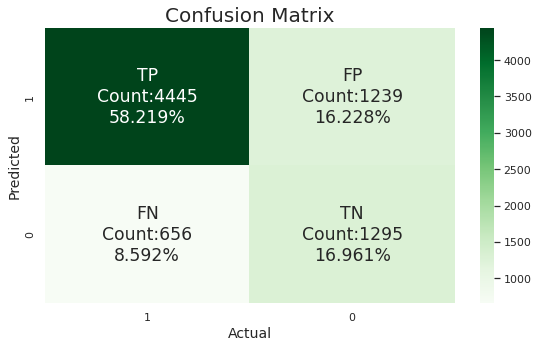

In [ ]:
confusion_heatmap(gbc_tuned)

The tuned gradient boosting classifier allows few false negatives, but comparatively more false positives. This explains the higher recall score, as compared to precision.

The percentage of true negatives is nearly identical to the percentage of false positives, around 16%. This means our model does a bad job at distinguishing Denied cases, as it's prediction is no better than random guessing. Put another way, there is only about a 50% chance that our model will correctly identify when a case is Denied.

In [ ]:
# z-test
num_obs=1239+1295
t,p_val=proportions_ztest([1239,1295],[num_obs,num_obs])
print('The p-value is',p_val)

The p-value is 0.11565928243244895


We can run a two proportions z-test to check our model's ability to predict Denied cases. With a p-value greater than 0.05, our model is only as good as random guessing.

In [ ]:
# feature importance
ser=pd.Series(gbc_tuned.feature_importances_,index=X_train.columns)
ser=ser.sort_values(ascending=False)
print('Feature importance')
print('-'*10)
ser

Feature importance
----------


education_of_employee             0.443459
has_job_experience                0.150752
unit_of_wage_Hour                 0.100343
continent_Europe                  0.061272
prevailing_wage                   0.054921
unit_of_wage_Year                 0.030446
region_of_employment_Midwest      0.029068
continent_North America           0.022887
region_of_employment_South        0.021740
no_of_employees                   0.018451
region_of_employment_West         0.017778
years_in_business                 0.012811
full_time_position                0.008663
requires_job_training             0.008135
continent_South America           0.006894
region_of_employment_Northeast    0.005634
continent_Asia                    0.003787
region_of_employment_Island       0.000889
unit_of_wage_Week                 0.000589
continent_Oceania                 0.000537
unit_of_wage_Month                0.000521
continent_Africa                  0.000423
dtype: float64

* Education of the applicant is most important, i.e., has the greatest predictive impact on ```case_status```.
* Job experience is the next most influential feature.
* Continent of origin has less importance, as do the years in business and full time status of the role.

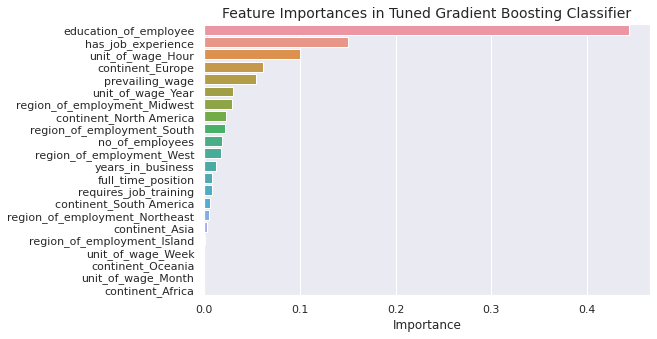

In [ ]:
plott()
plt.title('Feature Importances in Tuned Gradient Boosting Classifier',fontsize=14)
sns.barplot(x=ser,y=ser.index)
plt.xlabel('Importance');

Relative importance can be gleaned with the plot above. Education is massively more important than anything else.

### Other Good Models

#### Tuned Decision Tree

In [ ]:
mct.loc['dTree (tuned)']

Train Acc    0.749382
Test Acc     0.750098
Train F1     0.823571
Test F1      0.823497
Status        General
Name: dTree (tuned), dtype: object

The tuned decision tree also performed well on test data, with around 75% accuracy and 82% F1 score. This seems like the upper limit for performance.

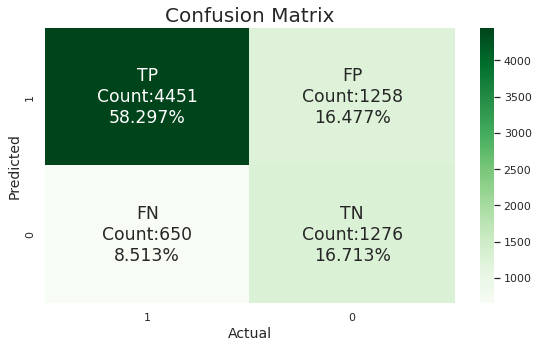

In [ ]:
confusion_heatmap(dtree_tuned)

Our confusion matrix for the tuned decision tree looks quite similar to that for the tuned gradient boosting classifier. It seems there is a trend in our models being unable to predict Denied applications.

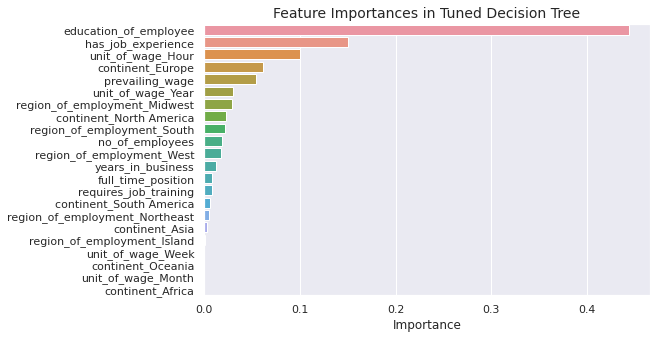

In [ ]:
# feature importance
ser=pd.Series(gbc_tuned.feature_importances_,index=X_train.columns)
ser=ser.sort_values(ascending=False)

plott()
plt.title('Feature Importances in Tuned Decision Tree',fontsize=14)
sns.barplot(x=ser,y=ser.index)
plt.xlabel('Importance');

Once more, education and job experience are the most important features in predicting ```case_status```.

#### Stacking Classifier

In [ ]:
mct.loc['Stacking']

Train Acc    0.754772
Test Acc     0.749836
Train F1     0.826446
Test F1      0.822259
Status        General
Name: Stacking, dtype: object

Despite stacking multiple models together, nothing was gained by implementing the stacking classifier. Accuracy is still around 75% and F1 is at 82%.

It is possible that most of the models misclassified the same records, i.e., had the same false positives and false negatives. If this is the case, then stacking them together would not add any predictive power.

We can get an idea from the confusion matrix.

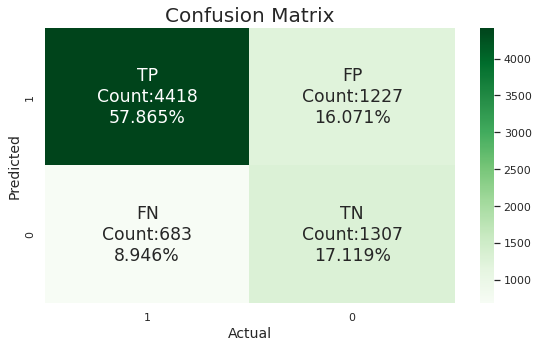

In [ ]:
confusion_heatmap(stack)

Here, it appears the stacking classifier is slightly better than earlier models at predicting Denied cases. We can check whether its performance is better than random guessing with a two proportions z-test (significance=0.05).

In [ ]:
# z-test
num_obs=1227+1307
t,p_val=proportions_ztest([1227,1307],[num_obs,num_obs])
print('The p-value is',p_val)

The p-value is 0.024607436753421648


With a p-value less than 0.05, we find that there is in fact a significant difference between the number of true negatives and false negatives. Thus the stacking classifier is better at predicting Denied cases than randomly guessing.

## Actionable Insights and Recommendations

* Our model can correctly predict 75% of case statuses. While this is fairly good&mdash;certainly better than guessing&mdash;there's much room for improvement.
* Our chosen scoring metric was F1, as it provides a good balance of recall and precision. Models maxed out at 82% for the F1 score. Meta-ensemble methods like the stacking classifier could not further improve this score.
* Level of education has the greatest influence on case status prediction. One way for OFLC to manage the number of applications is to process an initial short form application to immediately rule out candidates. If this approach were used, level of education would surely be one of the most helpful questions to ask.
* Previous job experience also has a big impact on case status. This too would be good to check on an initial automated screening. If the candidate passes the screening, they would be permitted to submit a complete application to be reviewed by a case reviewer at OFLC.
* As was seen in the EDA, a higher level of education leads to a greater chance of being Certified. The ideal candidate has a Doctorate and previous job experience, is from Europe, and is seeking part-time employment in the Midwest.
* Using machine learning models like those developed here, OFLC could in fact automate the entire screening! We could, for example, use a stacking classifier with a number of the estimators found above and logistic regression as the final estimator. Then we define two cutoffs: high probability of Certification and high probability of Denied. We can then assign statuses to the most obvious cases, leaving the more complicated cases on the edge for the reviewers at OFLC to consider. In effect, we will cut down on the number of applications that need to be reviewed by a human, while still allowing growth to the US job market.